# Prediction Task:
## _Predict bike rental demand as a function of suitable features available in or derived from the data sets_

## Libraries and styles

In [1]:
# importing all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from haversine import haversine, Unit
from matplotlib.dates import date2num

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Reading Function

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [4]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [5]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [6]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [7]:
dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

***

## Data for Prediction Task

### Prepare data
Since we have data sets with single entries (trips) at one specific point of time, it does not make sense to take a value from the single entries as a target (since there is no "rental demand" associated with a single trip). Rather, we have to group the trips by a time unit, e.g. hour or day, and aggregate the number of trips per time unit, so there is a target associated with our data that can be predicted.

In [8]:
dataBr.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,distance_from_center_start,distance_from_center_end
0,0,2019-04-21,2021-02-03 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0,5.486415,6.488083
1,1,2019-05-23,2021-02-03 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0,5.486415,4.947560
2,2,2019-06-14,2021-02-03 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0,5.486415,4.913475
3,3,2019-06-16,2021-02-03 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0,4.913475,5.486415
4,4,2019-06-16,2021-02-03 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0,5.486415,5.922224


#### Drop columns that are obviously neither relevant nor useful

In [9]:
dBr = dataBr.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)
dDu = dataDu.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)

In [10]:
# group the trips by either hour or day
def process_data_for_city(data, city, start_date, end_date, group):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window. Also groups by 
    a given param (hour or day)

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param group: a string, either "hour" or "day"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate on several columns
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    grouping = [times.month, times.day, times.hour] if group == "hour" else  [times.month, times.day]
    dat_time_framed["inner"] = dat_time_framed["distance_from_center_start"] <= 1
    groupedBy = dat_time_framed.groupby(grouping).agg(trips_per_time=("datetime_start","count"), revenue_per_time=("revenue_per_trip","sum"), avg_temp=("temp","mean"), avg_wind=("wind","mean"), avg_rain=("rain","mean"), avg_distance=("distance","mean"), innerCity=("inner","sum"), innerCityMean=("inner","mean"),avg_dist_from_center_start=("distance_from_center_start","mean"), avg_dist_from_center_end=("distance_from_center_end","mean"))
   
    # reset index to get the groupedBy values back as columns
    groupedBy.index.rename(["month", "day", "hour"] if group == "hour" else ["month","day"], inplace=True)
    groupedBy.reset_index(inplace=True)
    
    # generate string date column
    groupedBy["date"] = "2019-" + groupedBy["month"].astype(str) + "-" +  groupedBy["day"].astype(str) + " 00:00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedBy["datetime"] = [pd.to_datetime(d) for d in groupedBy.date]
    groupedBy.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedBy["weekday"] = [dt.weekday() for dt in groupedBy.datetime]
    groupedBy.drop(["datetime"], axis=1, inplace=True)


    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedBy["is_weekday"] = groupedBy["weekday"] <=4
    groupedBy.drop(["weekday"], axis=1, inplace=True)
    
    # function determining the peak time; col1 (weekdays) at rush hour time and col2(weekend) spread over the noon/afternoon
    def isPeaktime(col1, col2):
        if ( ((col1 == True) and (col2 in (5,6,7,8,15,16,17))) or ((col1 == False) and (col2 in (10,11,12,13,14,15,16)))):
            return True
        else: 
            return False
    
    # function determining dark hours; based on col1(hour)
    def isDark(col1):
        if col1 > 19 or col1 < 6:
            return True
        else: 
            return False
        
    # function determining rainy hours
    def isRainy(col1):
        if col1 > 0.3:
            return True
        else: 
            return False
        
    # function determining windy hours
    def isWindy(col1):
        if col1 >= 8:
            return True
        else: 
            return False
        
    groupedBy["is_peaktime"] = groupedBy.apply(lambda row: isPeaktime(row.is_weekday, row.hour), axis=1)
    groupedBy["is_dark"] = groupedBy.apply(lambda row: isDark(row.hour), axis=1)
    groupedBy["is_rainy"] = groupedBy.apply(lambda row: isRainy(row.avg_rain), axis=1)
    groupedBy["is_windy"] = groupedBy.apply(lambda row: isWindy(row.avg_wind), axis=1)
    
    return groupedBy

In [11]:
TIME_FRAME="hour"

In [12]:
br = process_data_for_city(dBr, city1, startDate, endDate, TIME_FRAME)
du = process_data_for_city(dDu, city2, startDate, endDate, TIME_FRAME) 

***
## Correlation Analysis

The goal is to select those features (from the set of all features) that are optimally least correlated with each other and highly correlated with the target. As a guideline we could take a boundary correlation value of 0.3 or -0.3 to detect very low correlation and take at least low to medium correlation into consideration. However, some features with low correlation values still might be valuable for the prediction task, and a low correlation value might not filter those out (e.g. wind strength obviously has an impact on driven distance). As a result, all features with correlation below between 0.05 and -0.05 are considered not correlated with each other and are assumed to be able to be independently used in a feature set. The same values apply to selecting those features correlated with the target. However, correlation with the target should be maximized.

https://journals.sagepub.com/doi/pdf/10.1177/875647939000600106
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/

#### on unprepared data

In [13]:
# showing the highest correlation values for a given data set with a given correlation metric
# disregards values equal to 1 at the diagonal
def show_high_corr(data, posMin, negMin, corr_method):
    corr = data.corr(method=corr_method)
    corr_val = np.array(corr)
    rows, cols = corr.shape
    flds = list(corr.columns)
    high_corr = []
    
    for i in range(cols):
        for j in range(i, cols):
            if corr_val[i,j] > posMin or corr_val[i,j] < negMin:
                if(i!=j):
                    high_corr.append([flds[i], flds[j], corr_val[i,j]])
    df = pd.DataFrame(high_corr, columns = ['col1', 'col2', 'correlation'])
    return df

In [14]:
# BREMEN, PEARSON CORRELATION
all_br_pe = show_high_corr(dBr, 0.05, -0.05, "pearson")
all_br_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.070743
1,orig_lat,dest_lat,0.666620
2,orig_lat,dest_lng,-0.069857
3,orig_lat,distance,0.098017
4,orig_lat,trip_duration_hours,0.056897
5,orig_lat,distance_from_center_end,-0.064568
6,orig_lng,dest_lat,-0.066708
7,orig_lng,dest_lng,0.642663
8,orig_lng,distance,0.050057
9,orig_lng,distance_from_center_start,0.519234


In [15]:
# BREMEN, SPEARMAN CORRELATION
all_br_sp = show_high_corr(dBr, 0.05, -0.05, "spearman")
all_br_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.455863
1,orig_lat,distance,0.060518
2,orig_lat,trip_duration_hours,0.050182
3,orig_lng,dest_lng,0.516679
4,orig_lng,distance_from_center_start,0.557024
5,orig_lng,distance_from_center_end,0.316041
6,dest_lat,hour,-0.065336
7,dest_lat,distance,0.056946
8,dest_lng,hour,0.088366
9,dest_lng,distance_from_center_start,0.317261


##### Bremen
- geo coordinates have a strong positive correlation with each other
- geo coordinates have a strong positive correlation with distance from city center

**-->** remove geo coordinates or take only one out of those features with geo coordinates / distance from center

- month, hour and week are highly positively correlated with temp

**-->** try maybe with one out of [month,day,hour] plus temperature (e.g. since both hour and temp could be a valuable feature), or only temperature, or only time values

- distance is highly correlated with trip duration in hours, average speed

**-->** here, take only one feature, since they all rely on each other


**lower correlation values that still might be relevant**
- distance is negatively correlated with wind
- trip duration is positively correlated with wind
- avg speed is negatively correlated with temperature
- temperature is negatively correlated with rain
- weekday is positively correlated with trip duration and negatively correlated with average speed

In [16]:
# DÜSSELDORF, PEARSON CORRELATION
all_du_pe = show_high_corr(dDu, 0.05, -0.05, "pearson")
all_du_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.111232
1,orig_lat,dest_lat,0.720237
2,orig_lat,dest_lng,-0.098727
3,orig_lat,month,-0.115170
4,orig_lat,week,-0.127535
5,orig_lat,distance,0.218181
6,orig_lat,trip_duration_hours,0.064961
7,orig_lat,avg_speed,0.072530
8,orig_lat,temp,-0.107898
9,orig_lat,distance_from_center_start,0.114302


In [17]:
# DÜSSELDORF, SPEARMAN CORRELATION
results_du_sp = show_high_corr(dDu, 0.05, -0.05, "spearman")
results_du_sp

,col1,col2,correlation
0,orig_lat,orig_lng,-0.112720
1,orig_lat,dest_lat,0.625418
2,orig_lat,dest_lng,-0.104434
3,orig_lat,month,-0.178435
4,orig_lat,week,-0.195161
5,orig_lat,distance,0.127378
6,orig_lat,trip_duration_hours,0.102637
7,orig_lat,temp,-0.133824
8,orig_lat,distance_from_center_end,-0.075555
9,orig_lng,dest_lat,-0.111214


##### Düsseldorf
- similar to Bremen


#### on prepared data

In [18]:
# BREMEN, PEARSON CORRELATION
prep_br_pe = show_high_corr(br, 0.05, -0.05, "pearson")
prep_br_pe

,col1,col2,correlation
0,month,trips_per_time,0.338867
1,month,revenue_per_time,0.329102
2,month,avg_temp,0.687527
3,month,avg_wind,-0.113449
4,month,avg_distance,0.151357
5,month,innerCity,0.221351
6,month,innerCityMean,-0.083954
7,month,avg_dist_from_center_start,0.053164
8,month,avg_dist_from_center_end,0.075282
9,month,is_windy,-0.177736


In [19]:
# BREMEN, SPEARMAN CORRELATION
prep_br_sp = show_high_corr(br, 0.05, -0.05, "spearman")
prep_br_sp

,col1,col2,correlation
0,month,trips_per_time,0.315185
1,month,revenue_per_time,0.319983
2,month,avg_temp,0.697175
3,month,avg_wind,-0.077939
4,month,avg_distance,0.174323
5,month,innerCity,0.212236
6,month,innerCityMean,-0.074162
7,month,avg_dist_from_center_start,0.137824
8,month,avg_dist_from_center_end,0.145631
9,month,is_windy,-0.178611


In [20]:
# DÜSSELDORF, PEARSON CORRELATION
prep_du_pe = show_high_corr(du, 0.05, -0.05, "pearson")
prep_du_pe

,col1,col2,correlation
0,month,trips_per_time,0.519501
1,month,revenue_per_time,0.468922
2,month,avg_temp,0.608237
3,month,avg_wind,-0.145120
4,month,avg_distance,-0.075954
5,month,innerCity,0.337312
6,month,avg_dist_from_center_start,-0.090167
7,month,avg_dist_from_center_end,-0.098002
8,month,is_weekday,-0.053011
9,month,is_peaktime,-0.119233


In [21]:
# DÜSSELDORF, SPEARMAN CORRELATION
prep_du_sp = show_high_corr(du, 0.05, -0.05, "spearman")
prep_du_sp

,col1,col2,correlation
0,month,trips_per_time,0.567465
1,month,revenue_per_time,0.520294
2,month,avg_temp,0.633726
3,month,avg_wind,-0.109163
4,month,avg_distance,-0.055085
5,month,innerCity,0.360803
6,month,innerCityMean,0.177802
7,month,avg_dist_from_center_start,0.134077
8,month,avg_dist_from_center_end,0.124602
9,month,is_weekday,-0.056881


similar to above, but:
- month is highly correlated with num of trips (**target**), revenue and avg temp
- hour is highly correlated with num of trips (**target**)
- day is slightly correlated with num of trips (**target**), revenue and avg temp
- num of trips (**target**) is highly correlated with revenue and temp

**condensed for target variable: correlation of features with target variable on prepared data set**

In [22]:
target_corr_br = pd.DataFrame(data=pd.DataFrame(data=br.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_br["spearman"] = pd.DataFrame(data=br.corr(method="spearman"))["trips_per_time"]
target_corr_br

,pearson,spearman
month,0.338867,0.315185
day,0.117279,0.119769
hour,0.217539,0.250862
trips_per_time,1.000000,1.000000
revenue_per_time,0.934448,0.978444
avg_temp,0.561897,0.542163
avg_wind,0.115841,0.180100
avg_rain,-0.079403,-0.089665
avg_distance,-0.016287,0.059868
innerCity,0.836820,0.856237


In [23]:
target_corr_du = pd.DataFrame(data=pd.DataFrame(data=du.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_du["spearman"] = pd.DataFrame(data=du.corr(method="spearman"))["trips_per_time"]
target_corr_du

,pearson,spearman
month,0.519501,0.567465
day,0.164119,0.143165
hour,0.133344,0.124287
trips_per_time,1.000000,1.000000
revenue_per_time,0.944414,0.949076
avg_temp,0.679965,0.671488
avg_wind,0.007316,0.034251
avg_rain,-0.051334,-0.093836
avg_distance,-0.005307,0.110632
innerCity,0.697039,0.615744


### Suitable features
#### those features from pepared data set with corr > 0.05 or < -0.05 and which are assumed to have impact on rental, sorted by assumed impact on rental demand
- temp
- month
- hour
- day
- wind
- rain
- distance from city center
- weekday

***
## Select features

In [24]:
# all possible pre-selected features
# ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "innerCityMean", is_peaktime", "is_dark", "is_rainy", "is_windy"]

##### split into weekday, weekend and combined

In [25]:
x_br_weekday = br[br["is_weekday"]==True][["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
x_br_weekend = br[br["is_weekday"]==False][["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain","avg_distance", "avg_dist_from_center_end", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
x_br_full    = br[["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "is_peaktime", "is_dark","is_rainy", "is_windy"]]
y_br_weekday = br[br["is_weekday"]==True]["trips_per_time"]
y_br_weekend = br[br["is_weekday"]==False]["trips_per_time"]
y_br_full = br["trips_per_time"]

##### automatically select k best features (features n=9)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

In [27]:
br_new_wd = SelectKBest(f_regression, k=3).fit_transform(x_br_weekend,y_br_weekend)
# br_new_wd = SelectKBest(mutual_info_regression, k=3).fit_transform(x_br_weekend,y_br_weekend)
pd.DataFrame(br_new_wd)

,0,1,2
0,-1.75,False,True
1,-1.5,False,True
2,-1.5,False,True
3,-1.3,False,True
4,-1.3,False,True
...,...,...,...
976,21.3577,False,False
977,19.8,False,True
978,17.7917,False,True
979,16.4,False,True


#### results from playing around with x_br_weekday, x_br_weekend, x_br_full with k = 1,...,8
##### best k features from k=1 to k=8 on weekdays
- hour
- hour, temp
- hour, temp, avg_dist_from_center_end
- hour, temp, avg_distance, avg_dist_from_center_end
- hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_rain, avg_dist_from_center_end
- month, day, hour, temp, avg_distance, avg_wind, avg_rain, avg_dist_from_center_end

##### best k features from k=1 to k=8 on weekends
- temp
- hour, temp
- hour, temp, avg_distance_from_city_center_end
- day, hour, temp, avg_distance_from_city_center_end
- day, hour, temp, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, wind, avg_distance, avg_distance_from_city_center_end
- month, day, hour, temp, wind, rain, avg_distance, avg_distance_from_city_center_end

##### best k features from k=1 to k=8 on all days
- hour
- hour, temp
- hour, temp, avg_dist_from_center_end
- hour, temp, avg_distance, avg_dist_from_center_end
- hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end
- month, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end, is_weekday
- month, day, hour, temp, avg_distance, avg_wind, avg_dist_from_center_end, is_weekday

##### for both weekday and weekend  temperature the 3 most important features seem to be hour, temp and avg_dist_from_center_end

***
# Prediction

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

##### selected features for prediction

In [29]:
# all possible pre-selected features
# ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "innerCityMean", is_peaktime", "is_dark", "is_rainy", "is_windy"]

In [119]:
# SELECT FEATURES HERE
city = "Bremen"
# city = "Düsseldorf"

if city == "Bremen":
    features = ["hour", "month", "avg_temp","avg_wind","is_weekday","innerCityMean", "is_peaktime", "is_dark"]
    X_full = br[features]
    y_full = br["trips_per_time"]
else:
    features = ["hour", "month", "avg_temp","avg_wind","is_weekday", "innerCityMean","is_peaktime", "is_dark"]
    X_full = du[features]
    y_full = du["trips_per_time"]

In [110]:
SPLIT_TRAIN = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

In [88]:
# SPLIT_TRAIN = 0.5
# SPLIT_VALIDATION = 0.3
# SPLIT_TEST = 0.2
# # generate Training set with 50% of orig. data, and 50% rest for validation and test
# X_train, X_split, y_train, y_split = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

# # split the other 50% of orig. data:
# # 0.3/0.5 = 0.6, 0.6 * 50% = 30% for Validation set, and 0.4 * 50% = 20% for Test set
# X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, random_state=0, train_size=SPLIT_VALIDATION/SPLIT_TRAIN)

#### visualized target values, train and test

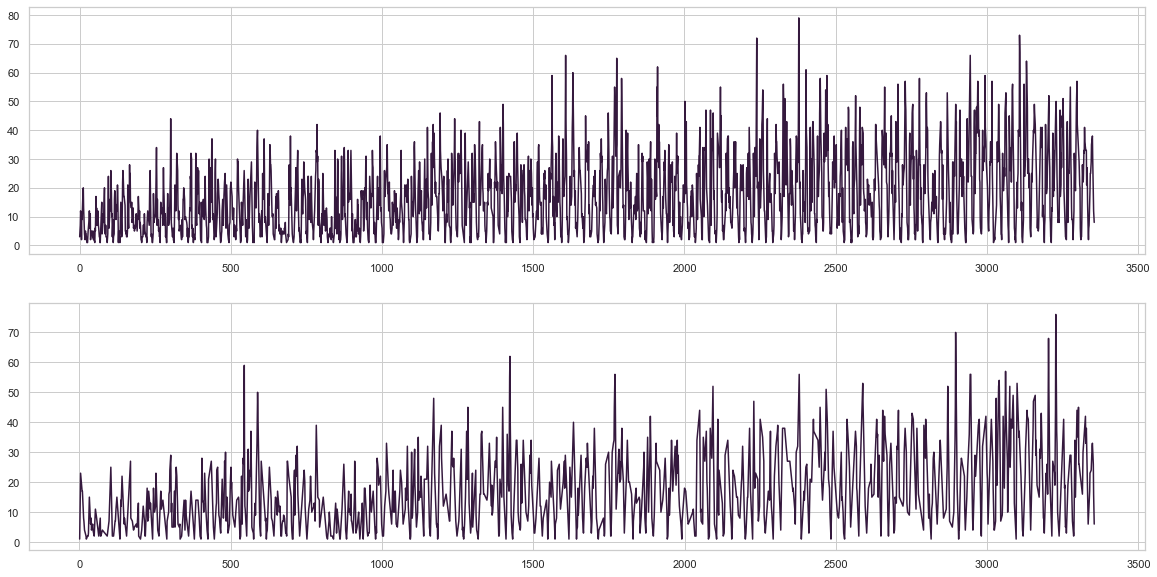

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(data=y_train, ax=ax1)
sns.lineplot(data=y_test, ax=ax2)

In [120]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

## Model 1: Histogram Gradient Boosting regression

In [123]:
## Histogram gradient Boosting
histgrad = HistGradientBoostingRegressor(max_iter=72).fit(X_train, y_train)

# prediction on test data
y_pred_histgrad = histgrad.predict(X_test)

# evaluate
r2_histgrad = r2_score(y_test, y_pred_histgrad)
MAE_histgrad =  mean_absolute_error(y_test, y_pred_histgrad)
MSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = True)
RMSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = False)

print (f'Histogram Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of histogram gradient boosting regression is: ', r2_histgrad)
print ('The MAE  of histogram gradient boosting regression is: ', MAE_histgrad)
print ('The MSE  of histogram gradient boosting regression is: ', MSE_histgrad)
print ('The RMSE of histogram gradient boosting regression is: ', RMSE_histgrad, "\n\n")

Histogram Gradient Boosting Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of histogram gradient boosting regression is:  0.7747155489861347
The MAE  of histogram gradient boosting regression is:  4.599680670688424
The MSE  of histogram gradient boosting regression is:  40.45303567166355
The RMSE of histogram gradient boosting regression is:  6.360270094238416 




## Model 2: Gradient Boosting Regression

In [124]:
## Gradient Boosting
grad = GradientBoostingRegressor(n_estimators=450, loss='ls').fit(X_train, y_train)

# prediction on test data
y_pred_grad  = grad.predict(X_test)

# evaluate
r2_grad = r2_score(y_test, y_pred_grad)
MAE_grad =  mean_absolute_error(y_test, y_pred_grad)
MSE_grad = mean_squared_error(y_test, y_pred_grad, squared = True)
RMSE_grad = mean_squared_error(y_test, y_pred_grad, squared = False)

print (f'Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of gradient boosting regression is: ', r2_grad)
print ('The MAE  of gradient boosting regression is: ', MAE_grad)
print ('The MSE  of gradient boosting regression is: ', MSE_grad)
print ('The RMSE of gradient boosting regression is: ', RMSE_grad)

Gradient Boosting Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of gradient boosting regression is:  0.7780953598448805
The MAE  of gradient boosting regression is:  4.597040901797884
The MSE  of gradient boosting regression is:  39.846142436835244
The RMSE of gradient boosting regression is:  6.312380092867922


In [68]:
def plot_results(predictions):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 40))

    for i in range(0,len(features)):
        axes[i].scatter(X_train[features[i]],y_train, marker='x', color='b')
        axes[i].scatter(X_test[features[i]],predictions, marker='x', color='r')
        axes[i].set_xlabel(features[i])
        axes[i].set_ylabel("Demand")
        axes[i].legend(["Training Set", 'Prediction Set'])

## Model 3: Linear regression

Linear Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of linear regression is:  0.5909157289911442
The MAE  of linear regression is:  6.628752559921808
The MSE  of linear regression is:  73.45691428486211
The RMSE of linear regression is:  8.57070092144523
Coefficients  [ 0.32181577  1.33323031  0.61565185 -0.12674431  2.728544    2.31938267
  7.63333672 -8.5254293 ] 
Intercept  0.12861161103040786


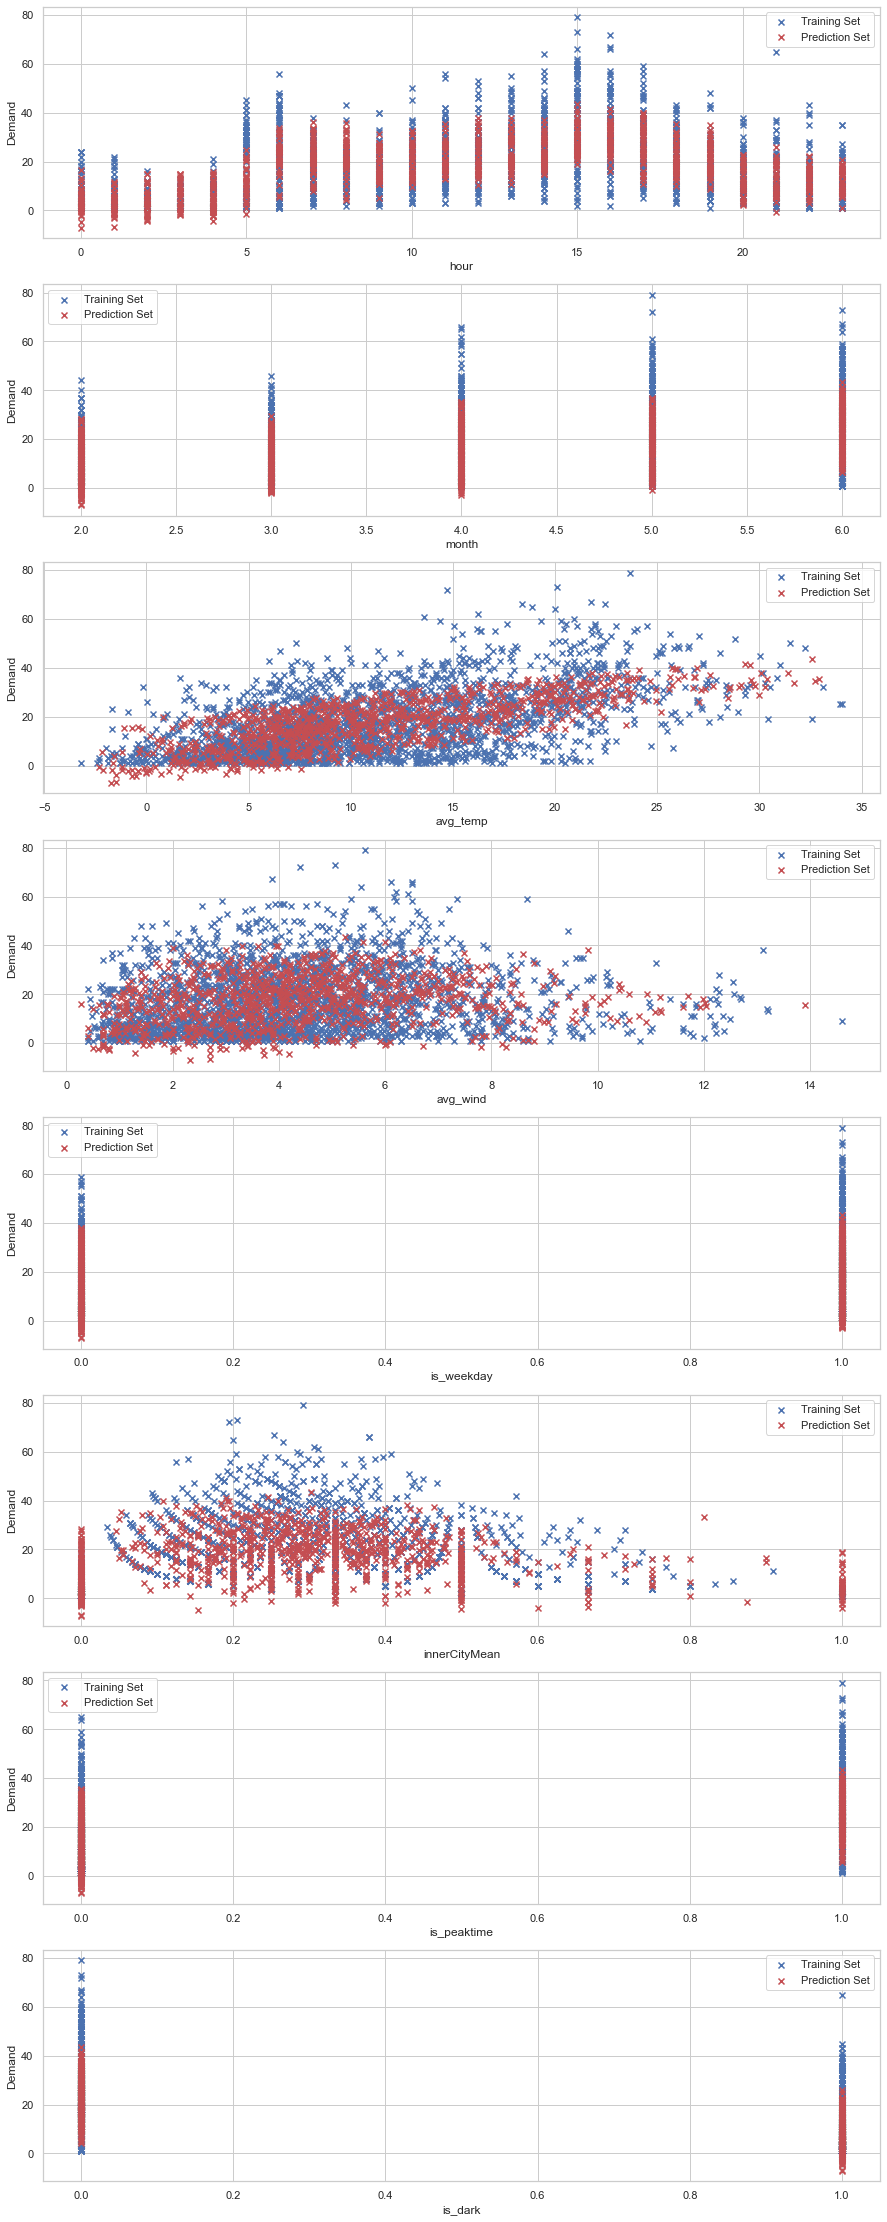

In [125]:
# fit model on training data
model_lin = LinearRegression(normalize = True)
model_lin.fit(X_train, y_train)

# prediction on test data
y_pred_lin = model_lin.predict(X_test)

# evaluate
r2_lin = r2_score(y_test, y_pred_lin)
MAE_lin =  mean_absolute_error(y_test, y_pred_lin)
MSE_lin = mean_squared_error(y_test, y_pred_lin, squared = True)
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared = False)

print (f'Linear Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of linear regression is: ', r2_lin)
print ('The MAE  of linear regression is: ', MAE_lin)
print ('The MSE  of linear regression is: ', MSE_lin)
print ('The RMSE of linear regression is: ', RMSE_lin)
print("Coefficients ", model_lin.coef_, "\nIntercept ", model_lin.intercept_ )
plot_results(y_pred_lin)

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Model 4: polynomial regression

### select best degree via grid search and cross validation

In [127]:
# using grid search to find best degree by the metrics r2 and MAE
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/grid_search.html
param_grid = [
    {'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8]}
  ]
  
pipeline_poly = Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression(normalize = True))])
Poly_GS = GridSearchCV(pipeline_poly, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)
Poly_GS.fit(np.array(X_train).reshape(y_train.shape[0],-1), y_train)

poly2 = PolynomialFeatures(degree = Poly_GS.best_params_["poly__degree"])
x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
PolyRegression = LinearRegression(normalize = True)
PolyRegression.fit(x_poly2, y_train)

LinearRegression(normalize=True)

### evaluate model

Polynomial Regression, hourly, degree: 4
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of polynomial regression is:  0.734229316246752
The MAE  of polynomial regression is:  5.14412217335998
The MSE  of polynomial regression is:  47.722916082170535
The RMSE of polynomial regression is:  6.9081774790584625
Coefficients  [-1.21996233e-10  9.42124455e-01 -1.24234365e+01 -2.34574040e+00
  3.62909758e+00 -5.61191732e+00 -1.12434062e+02  8.46713930e+01
 -1.29161311e+00  2.51290327e-01 -1.36906178e+00  2.20720395e-01
  9.83965765e-02  1.04377491e+00  9.84550126e+00 -2.51032846e+01
 -8.52354018e-01 -2.17217660e+00  2.83350707e+00  2.91804190e+00
  2.01575043e+00  5.41173930e+01  8.05696308e-01  5.50999108e+00
 -1.41199969e-01 -1.12796276e+00 -3.13410818e-01  3.70139998e+00
 -1.01004488e-01  8.94065055e-01 -8.73111195e-02 -1.19485684e+00
 -1.04570108e+01 -

ValueError: x and y must be the same size

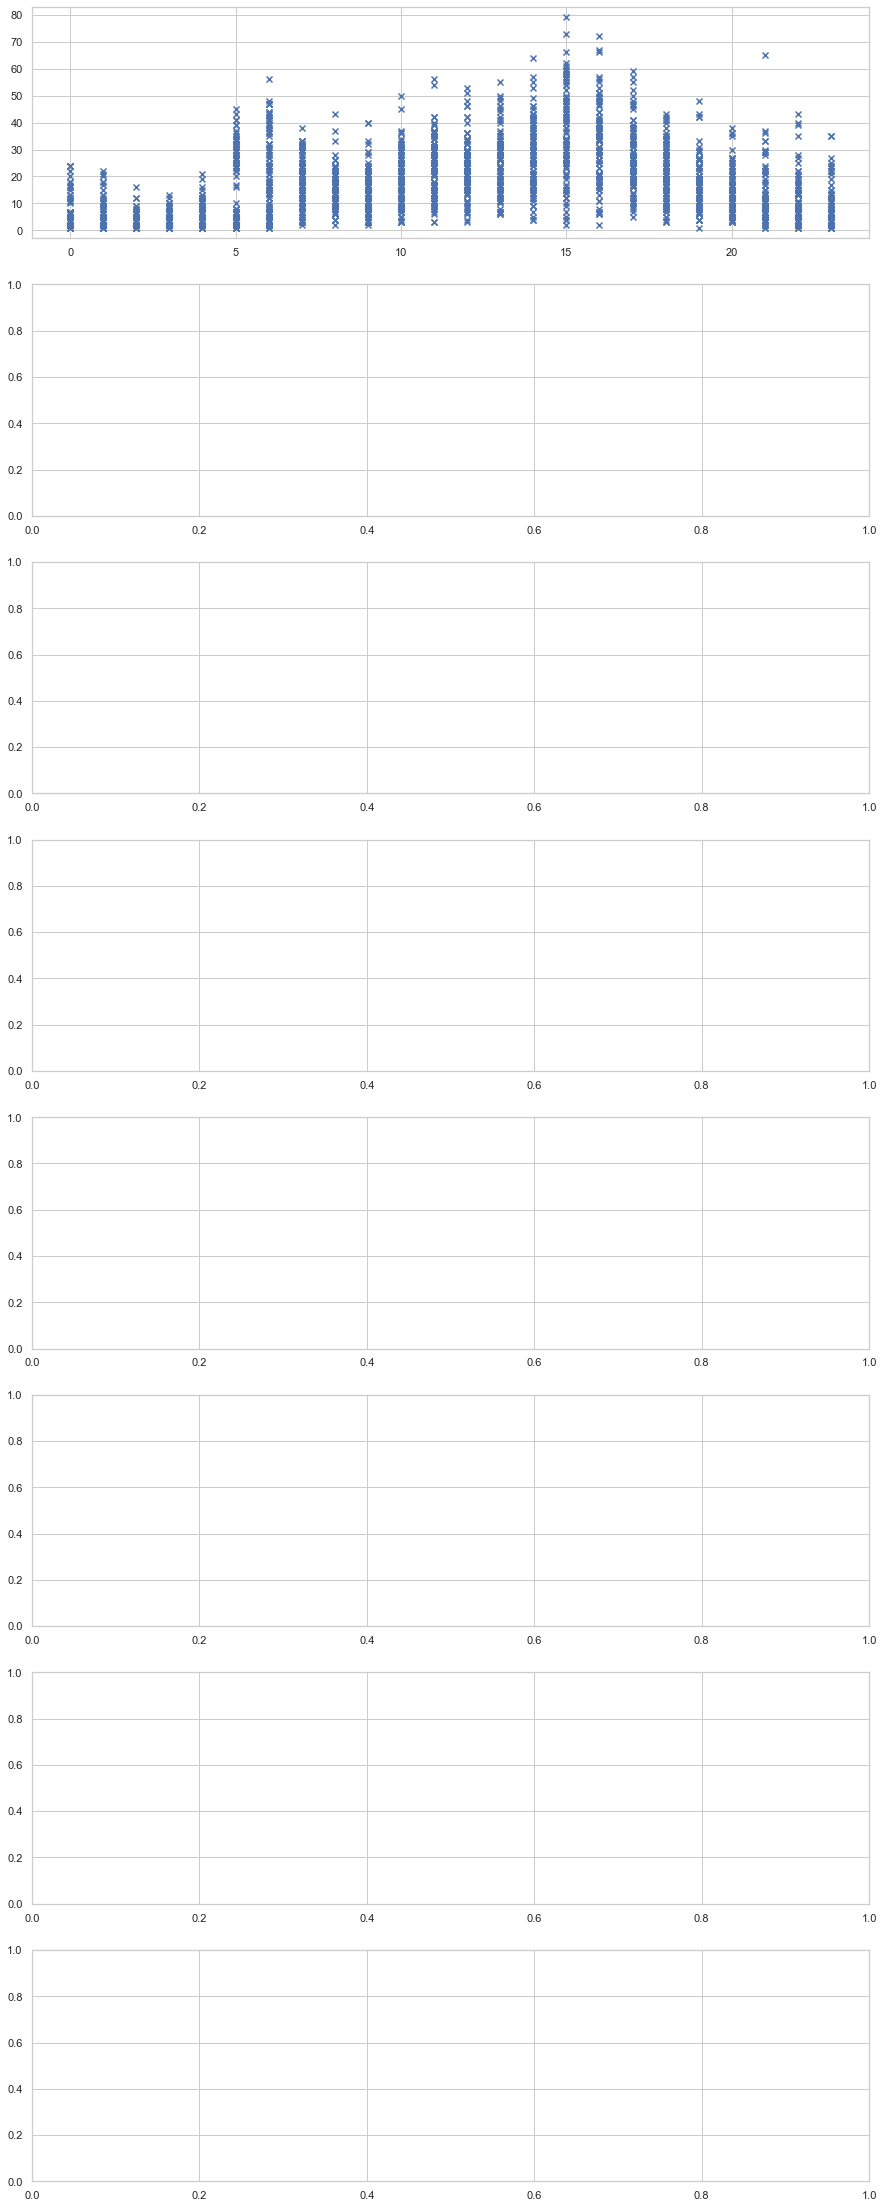

In [129]:
# prediction on test data
y_pred_poly = PolyRegression.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_poly = r2_score(y_test, y_pred_poly)
MAE_poly =  mean_absolute_error(y_test, y_pred_poly)
MSE_poly = mean_squared_error(y_test, y_pred_poly, squared = True)
RMSE_poly = mean_squared_error(y_test, y_pred_poly, squared = False)

print (f'Polynomial Regression, {TIME_FRAME}ly, degree: {Poly_GS.best_params_["poly__degree"]}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of polynomial regression is: ', r2_poly)
print ('The MAE  of polynomial regression is: ', MAE_poly)
print ('The MSE  of polynomial regression is: ', MSE_poly)
print ('The RMSE of polynomial regression is: ', RMSE_poly)
print("Coefficients ", PolyRegression.coef_, "\nIntercept ", PolyRegression.intercept_ )
plot_results(y_pred1)

## Model 5: Ridge regression

In [76]:
from sklearn.linear_model import Ridge

### select best params via grid search and cross validation

In [134]:
ridge = Ridge()
params_Ridge = {'alpha': [1,0.2, 0.15, 0.13, 0.11, 0.1,0.01,0.001,0.0001,0], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(ridge, param_grid=params_Ridge, n_jobs=-1, cv=5)
Ridge_GS.fit(X_train,y_train)

poly3 = PolynomialFeatures(degree = 7)
x_poly3 = poly3.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
Ridgeregression = Ridge(random_state=0, normalize=True, **Ridge_GS.best_params_)
Ridgeregression.fit(x_poly3,y_train)

Ridge(alpha=0.15, normalize=True, random_state=0, solver='sag')

### evaluate model

Ridge Regression, hourly
Params:  {'alpha': 0.15, 'solver': 'sag'}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of ridge regression is:  0.6985182249720112
The MAE  of ridge regression is:  5.3676446326121985
The MSE  of ridge regression is:  54.13535175054345
The RMSE of ridge regression is:  7.357672984751595
Coefficients  [ 0.          0.02753675  0.19102187 ... -0.0678868  -0.0678868
 -0.18150502] 
Intercept  5.8509814564130185


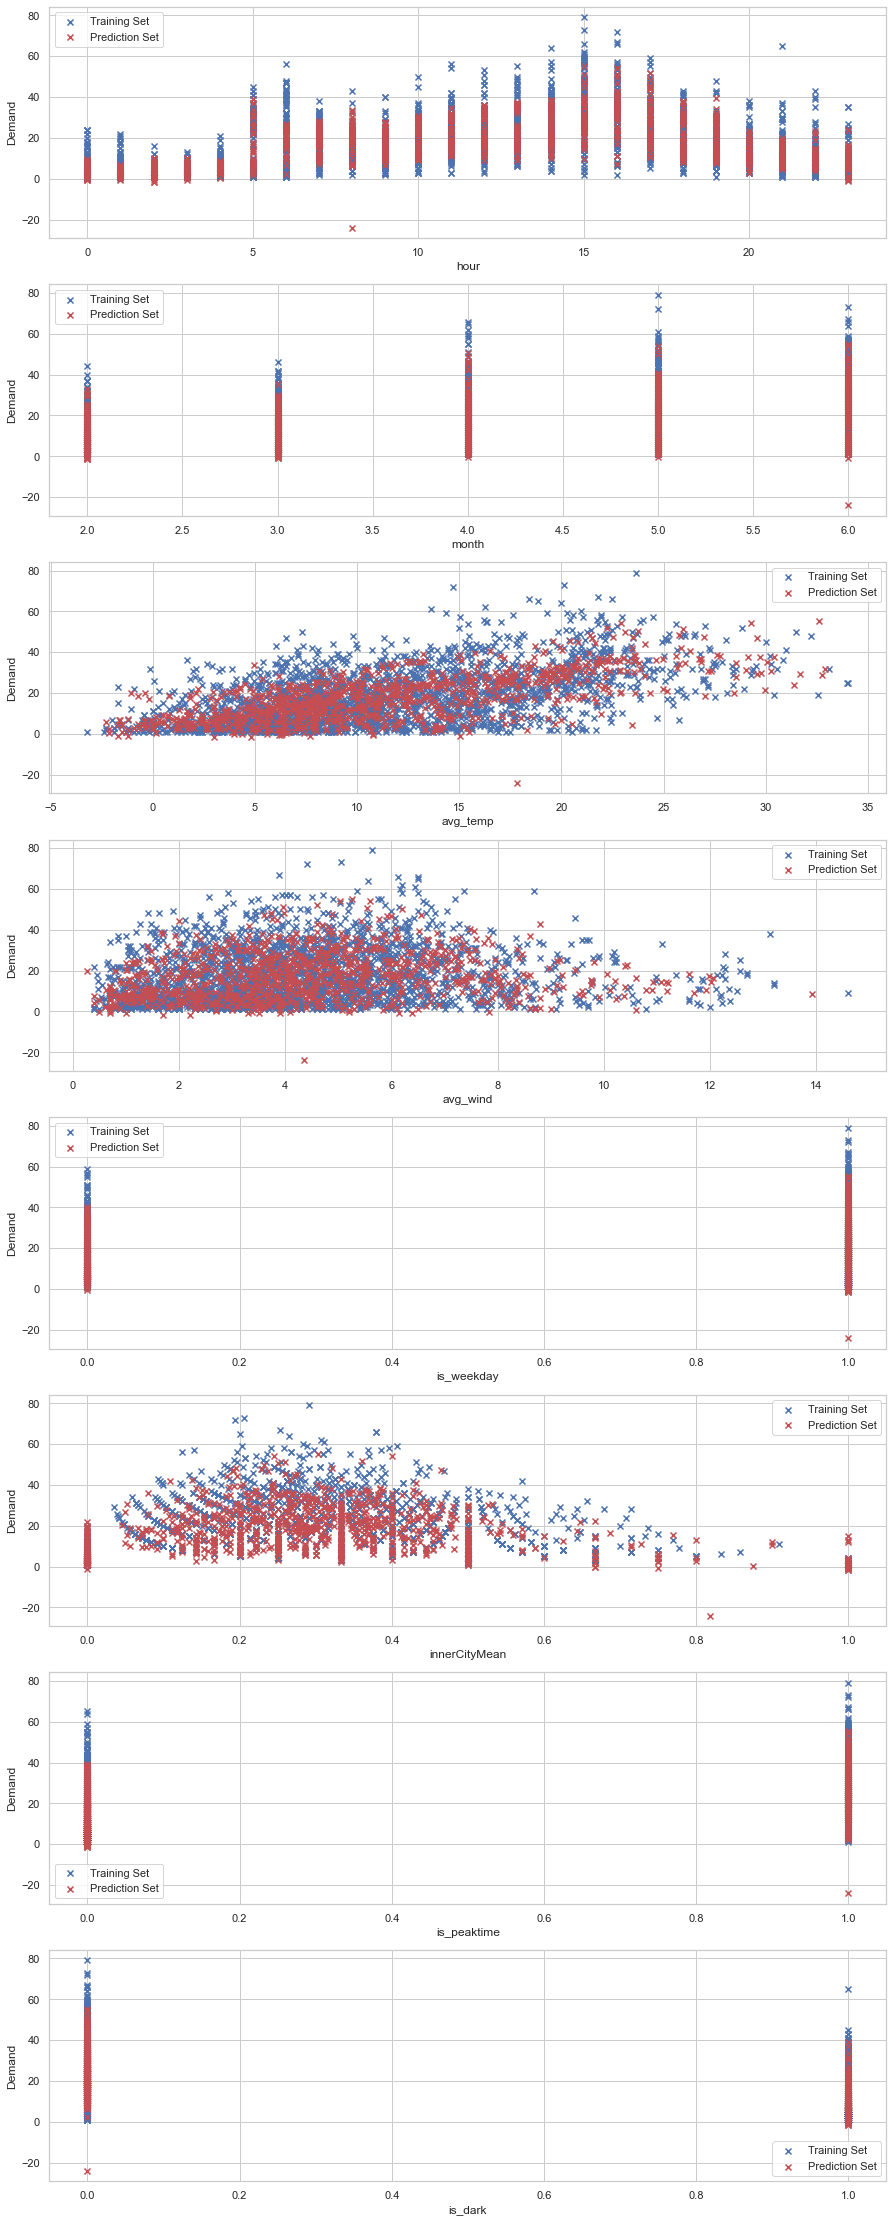

In [135]:
# prediction on test data
y_pred_ridge = Ridgeregression.predict(poly3.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
MAE_ridge =  mean_absolute_error(y_test, y_pred_ridge)
MSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = True)
RMSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = False)

print (f'Ridge Regression, {TIME_FRAME}ly')
print('Params: ', Ridge_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of ridge regression is: ', r2_ridge)
print ('The MAE  of ridge regression is: ', MAE_ridge)
print ('The MSE  of ridge regression is: ', MSE_ridge)
print ('The RMSE of ridge regression is: ', RMSE_ridge)
print("Coefficients ", Ridgeregression.coef_, "\nIntercept ", Ridgeregression.intercept_ )
plot_results(y_pred_ridge)

## Model 6: Lasso regression

In [128]:
from sklearn.linear_model import Lasso

### select best params via grid search and cross validation

In [137]:
lasso = Lasso()
params_lasso = {'alpha': [1,0.2, 0.15, 0.13, 0.11, 0.1,0.01,0.001,0.0001]}
Lasso_GS = GridSearchCV(lasso, param_grid=params_lasso, n_jobs=-1, cv=5)
Lasso_GS.fit(X_train,y_train)

poly4 = PolynomialFeatures(degree = 5)
x_poly4 = poly4.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
Lassoregression = Lasso(random_state=0, **Lasso_GS.best_params_)
Lassoregression.fit(x_poly4,y_train)

Lasso(alpha=0.0001, random_state=0)

### evaluate model

Lasso Regression, hourly
Params:  {'alpha': 0.0001}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of lasso regression is:  0.7261761600894729
The MAE  of lasso regression is:  5.1516787288954475
The MSE  of lasso regression is:  49.16897510592376
The RMSE of lasso regression is:  7.012059262864494
Coefficients  [ 0.          1.24659646  2.07464309 ... -0.         -0.
  4.1277395 ] 
Intercept  -13.409122482106241


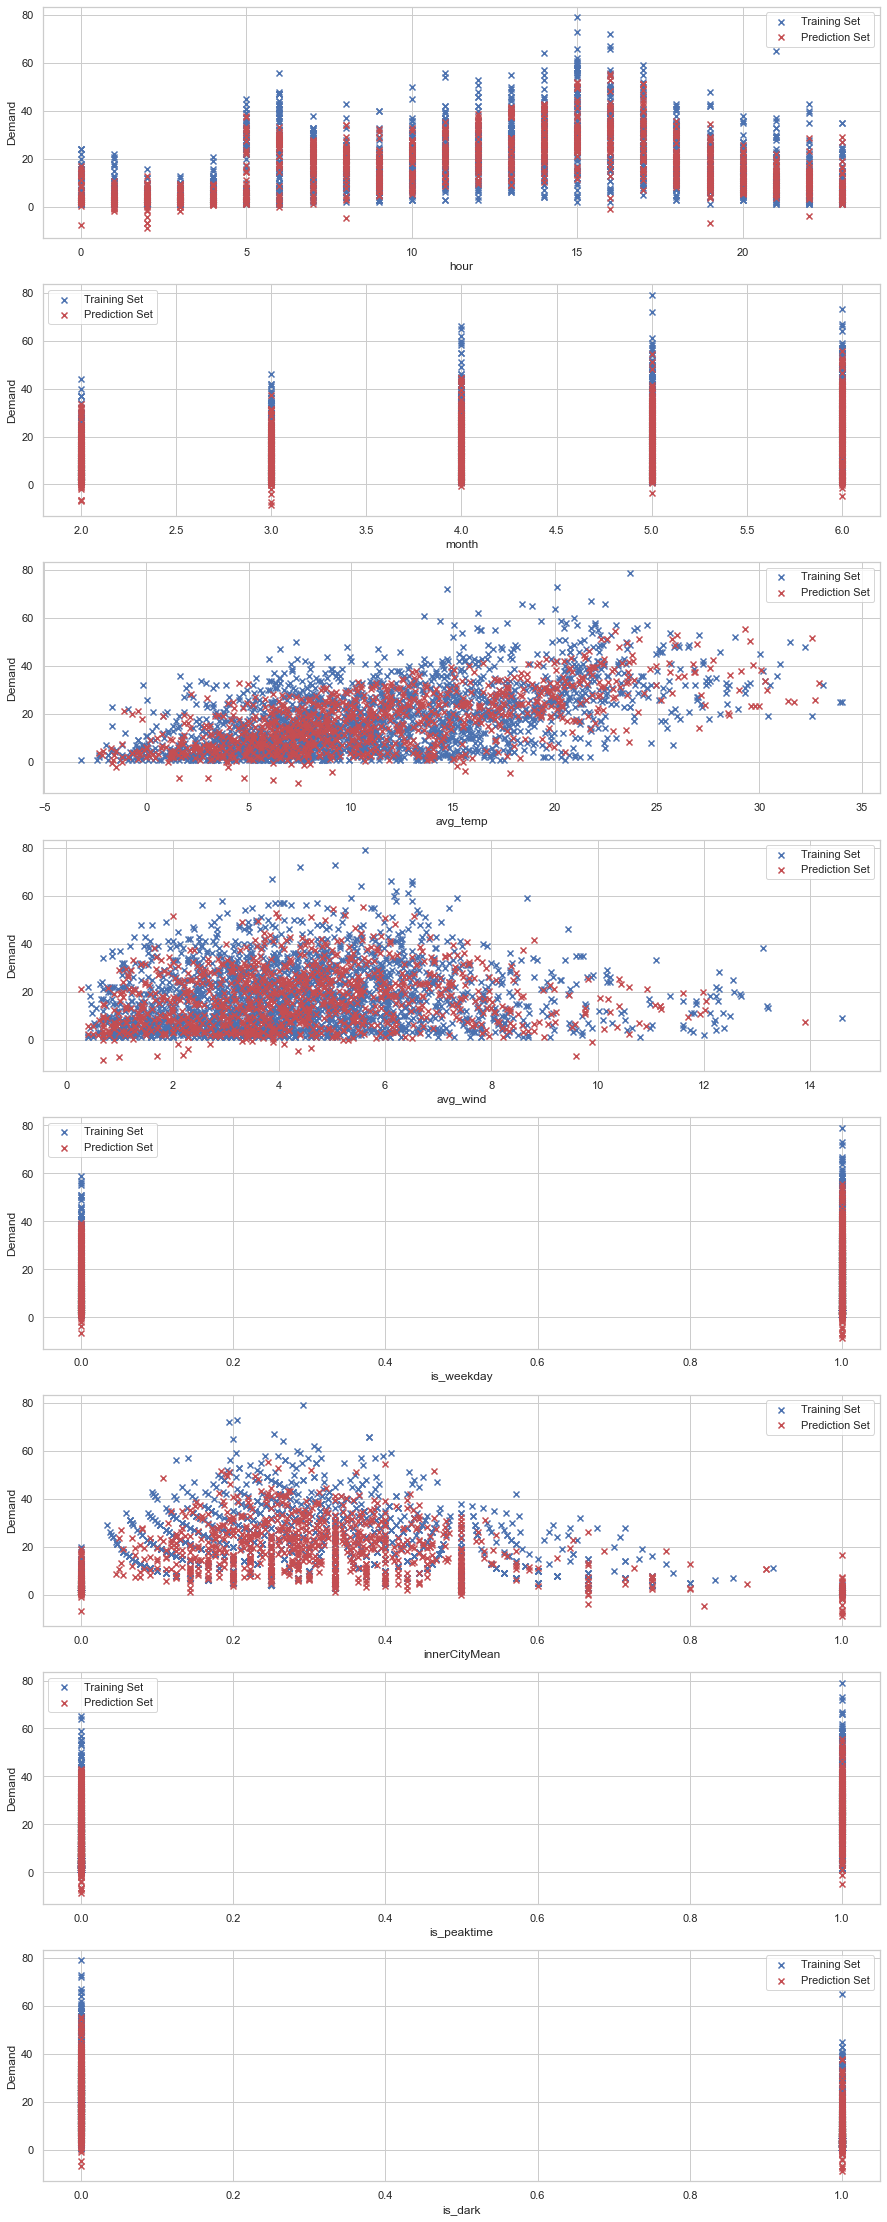

In [138]:
# prediction on test data
y_pred_lasso = Lassoregression.predict(poly4.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
MAE_lasso=  mean_absolute_error(y_test, y_pred_lasso)
MSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = True)
RMSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = False)

print (f'Lasso Regression, {TIME_FRAME}ly')
print('Params: ', Lasso_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of lasso regression is: ', r2_lasso)
print ('The MAE  of lasso regression is: ', MAE_lasso)
print ('The MSE  of lasso regression is: ', MSE_lasso)
print ('The RMSE of lasso regression is: ', RMSE_lasso)
print("Coefficients ", Lassoregression.coef_, "\nIntercept ", Lassoregression.intercept_ )
plot_results(y_pred_lasso)

## Model 7: Random Forest Regression

In [139]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(max_depth=2, random_state=0)
reg_rf.fit(X_train, y_train)

# prediction on test data
y_pred_reg_rf = reg_rf.predict(X_test)

# evaluate
r2_reg_rf = r2_score(y_test, y_pred_reg_rf)
MAE_reg_rf =  mean_absolute_error(y_test, y_pred_reg_rf)
MSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = True)
RMSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = False)

print (f'Random Forest Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of Random Forest regression is: ', r2_reg_rf)
print ('The MAE  of Random Forest regression is: ', MAE_reg_rf)
print ('The MSE  of Random Forest regression is: ', MSE_reg_rf)
print ('The RMSE of Random Forest regression is: ', RMSE_reg_rf)


Random Forest Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'innerCityMean', 'is_peaktime', 'is_dark']
The R^2  of Random Forest regression is:  0.5129406926178328
The MAE  of Random Forest regression is:  7.077967463004057
The MSE  of Random Forest regression is:  87.45844396750628
The RMSE of Random Forest regression is:  9.351921939767584


***
# Results for hourly demand prediction, Bremen

## Three Best Prediction models:
### Histogram Gradient Boosting regression
For training and test splits of 78% and 22% and features ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results: 
- The R^2  of Histogram gradient boosting regression is:  0.7655507952033939
- The MAE  of Histogram gradient boosting regression is:  4.66016110300944
- The MSE  of Histogram gradient boosting regression is:  42.19256538230443
- The RMSE of Histogram gradient boosting regression is:  6.49558044999093

### Gradient Boosting regression
For training and test splits of 80% and 20% and features ['hour', 'month', 'avg_temp', 'is_windy', 'is_rainy', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of boosting regression is:  0.7352673020222462
- The MAE  of boosting regression is:  4.963996291277663
- The MSE  of boosting regression is:  47.934768056570746
- The RMSE of boosting regression is:  6.923493919732345

### Polynomial Regression
For training and test splits of 80% and 20%, polynomial degree of 4 and features ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of polynomial regression is:  0.7332516318048576
- The MAE  of polynomial regression is:  5.114255564553397
- The MSE  of polynomial regression is:  48.299742557594335
- The RMSE of polynomial regression is:  6.949801620017245

## General explanation of results
The best prediction model, using histogram gradient boosting regression, yielded an r^2 score of roughly 76,55%, which means that the model could explain or predict about 3/4 of the provided data and its variance. The Mean Absolute Error of 4,66 Units indicates that the model could predict hourly bike rental demand with a mean deviation of +- 4,66 rentals. The MSE of 42,19 Units and RMSE of 6,49 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 4,66. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for futre projects is a more detailed selection of features. The comparison of boosting regressors with the other regression types suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results. As the boosting regressors have shown similar or worse results in comparison to the other regression types (polynomial, ridge, lasso) on the same features, including continuous weather data, they are comparably better when using simple categorical weather features indicating bad weather (is_windy, is_rainy). Also, the is_dark and hour features could be improved when integrating the fact that days get longer in the summer up to a certain maximum and then getting shorter again, which certainly has an impact on the rentals, as the feature is_dark suggests.

***
# Results for hourly demand prediction, Düsseldorf

## Three Best Prediction models:
### Histogram Gradient Boosting regression
For training and test splits of 65% and 35% and features ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy'] it yielded following results: 
- The R^2  of Histogram Gradient boosting regression is:  0.7411808660544513
- The MAE  of Histogram Gradient boosting regression is:  2.7880786787611775
- The MSE  of Histogram Gradient boosting regression is:  18.741496788001424
- The RMSE of Histogram Gradient boosting regression is:  4.329145041229437

### Gradient Boosting regression
For training and test splits of 65% and 36% and features ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'is_weekday', 'is_peaktime', 'is_dark', 'is_rainy', 'is_windy'] it yielded following results:
- The R^2  of Gradient boosting regression is:  0.7258787397115822
- The MAE  of Gradient boosting regression is:  2.9139391757316653
- The MSE  of Gradient boosting regression is:  19.84954760067746
- The RMSE of Gradient boosting regression is:  4.455283111170092

### Lasso Regression
For training and test splits of 80% and 20%, polynomial degree of 7, lambda = 0.1 and features ['hour', 'month', 'avg_temp', 'avg_wind', 'is_weekday', 'is_peaktime', 'is_dark'] it yielded following results:
- The R^2  of lasso regression is:  0.7225101697778884
- The MAE  of lasso regression is:  3.291866563147094
- The MSE  of lasso regression is:  21.779185685758467
- The RMSE of lasso regression is:  4.666817511512366

## General explanation of results
The best prediction model, using histogram gradient boosting regression, yielded an r^2 score of roughly 74,11%, which means that the model could explain or predict about 3/4 of the provided data and its variance. The Mean Absolute Error of 2.78 Units indicates that the model could predict hourly bike rental demand with a mean deviation of +- 2.78 rentals. The MSE of 18.74 Units and RMSE of 4.32 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 2.78. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

Also, the lower values for MAE, MSE and RMSE in Düsseldorf are most likely due to the fact that there are fewer data points in the Düsseldorf data set, which means there are less deviating values from the regression line.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for futre projects is a more detailed selection of features. The comparison of boosting regressors with the other regression types suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results. As the boosting regressors have shown similar or worse results in comparison to the other regression types (polynomial, ridge, lasso) on the same features, including continuous weather data, they are comparably better when using simple categorical weather features indicating bad weather (is_windy, is_rainy). Also, the is_dark and hour features could be improved when integrating the fact that days get longer in the summer up to a certain maximum and then getting shorter again, which certainly has an impact on the rentals, as the feature is_dark suggests.